In [3]:
from importlib import reload
import matplotlib.pyplot as plt
import dnd

from dnd import Dice

import pandas as pd
import numpy as np

In [26]:
import re
immunities = ['poison', 'fire', 'cold', 'lightning', 'bludgeoning', 'piercing', 'slashing', 'acid', 'necrotic', 'radiant', 
              'thunder', 'force', 'psychic',
              'slashing', 'bludgeoning', 'piercing']

conditions = {
'prone' : 'prone',
'blind' : 'blindness',
 'blinded' : 'blindness',
 'blindness': 'blindness',
'charmed' : 'charmed',
 'confusion': 'confusion',
'deafeed' : 'deafened',
 'deafened': 'deafened',
'exhausted': 'exhaustion',
 'exhaustion' : 'exhaustion',
'fright': 'frighened',
 'frightened' : 'frightened',
'grappled' : 'grappled',
'paralysis' : 'paralysis',
 'paralyzed' : 'paralysis',
 'petrification' : 'petrified',
 'petrified' : 'petrified',
'poisoned': 'poisoned',
'restrained' : 'restrained',
'stunned' : 'stunned',
'unconscious' : 'unconscious'
}

removed = set()
def map_immunities(value):
    
    if value == np.nan or type(value) != str:
        return []
    im=list([x for x in re.split('[,; "]+', value) if x != '' ])
    
    for a in im:
        if a not in immunities:
            removed.add(a)
    
    return list([x for x in im if x in immunities])

def map_condition_immunities(value):
    if value == np.nan or type(value) != str:
        return []
    im=list([x for x in re.split('[,; "]+', value) if x != '' ])
    for a in im:
        if a not in conditions:
            removed.add(a)
        

    return list([conditions[x] for x in im if x in conditions])



class Creature():
    
    def __init__(self, lines):
        


        comment_counter = 0
        for line in lines:
            if line.startswith('---'):
                comment_counter += 1
                if comment_counter == 2:
                    break
            else:
                try:
                    line = line.lower()

                    
                    parse_line = lambda x: x.split(': ')[1].strip()

                    parse_string = lambda x: x.split(': ')[1].strip().removeprefix('"').removesuffix('"')

                    parse_first_val = lambda x: int(x.split(': ')[1].split(' ')[0].strip())
                    parse_attribute = parse_first_val

                    parse_first_quote = lambda x: int(x.split(': ')[1].split(' ')[0].strip().removeprefix('"').removesuffix('"'))

                    parse_tags = lambda x: list([y for y in x.split(': ')[1].strip().removeprefix('[').removesuffix(']').split(',')])

                    
                    if line.startswith('name:'):
                        self.name = parse_string(line)
                    elif line.startswith('tags:'):
                        self.tags = parse_tags(line)
                    elif line.startswith('cha:'):
                        self.cha = parse_attribute(line)
                    elif line.startswith('wis:'):
                        self.wis = parse_attribute(line)
                    elif line.startswith('int:'):
                        self.int = parse_attribute(line)
                    elif line.startswith('con:'):
                        self.con = parse_attribute(line)
                    elif line.startswith('dex:'):
                        self.dex = parse_attribute(line)
                    elif line.startswith('str:'):
                        self.str = parse_attribute(line)
                    elif line.startswith('size:'):
                        self.size = line.split(': ')[1].strip()
                    elif line.startswith('alignment:'):
                        self.alignment = line.split(': ')[1].strip()
                    elif line.startswith('challenge:'):
                        self.challenge = parse_string(line)
                    elif line.startswith('languages:'):
                        self.languages = line.split(': ')[1].strip()
                    elif line.startswith('skills:'):
                        self.skills = line.split(': ')[1].strip()
                    elif line.startswith('speed:'):
                        self.speed = parse_line(line)
                    elif line.startswith('hit_points:'):
                        self.hit_points = parse_first_quote(line)
                    elif line.startswith('armor_class:'):
                        self.armor_class = parse_first_quote(line)
                    elif line.startswith('page_number:'):
                        self.page_number = parse_first_val(line)
                    elif line.startswith('senses:'):
                        self.senses = parse_line(line)
                    elif line.startswith('damage_resistances:'):
                        self.damage_resistances = map_immunities(parse_line(line))
                    elif line.startswith('layout:'):
                        pass
                    elif line.startswith('saving_throws:'):
                        self.saving_throws = parse_line(line)
                    elif line.startswith('damage_immunities:'):
                        self.damage_immunities = map_immunities(parse_line(line))
                    elif line.startswith('condition_immunities:'):
                        self.condition_immunities = map_condition_immunities(parse_line(line))
                    elif line.startswith('damage_vulnerabilities:') or line.startswith('damage_vulnerabilites:'):
                        self.damage_vulnerabilities = map_immunities(parse_line(line))

                        
                    else:
                        print(f'{self.name} Unparsed line: {line}')
                except:
                    print('error', line)
                    
                    print(self)

    def __str__(self):
        return str(vars(self))
    

    #look through all md files in the creatures directory reading each in
#and parsing the data into a pandas dataframe
import os



def read_creatures():
    creatures = []
    for filename in os.listdir('creatures'):
        if filename.endswith('.md'):
            with open('creatures/' + filename, 'r') as f:
                creature = Creature(f.readlines())
                creatures.append(creature)
                
    return creatures

creatures = read_creatures()

#Create a pandas dataframe from the creatures
df = pd.DataFrame([c.__dict__ for c in creatures])

import re
level_regex = re.compile('(\d+) .+')
fractionlevel_regex = re.compile('(\d+)/(\d+) .+')
def parse_level(value):
    level_match = level_regex.match(value)
    if level_match:
        return float(level_match.group(1))
    else:
        fraction_match = fractionlevel_regex.match(value)
        if fraction_match:
            numerator = float(fraction_match.group(1))
            denominator = float(fraction_match.group(2))
            return numerator / denominator
    return np.nan

df['challenge_level'] = df.challenge.astype(str).apply(parse_level)

# get all the unique tags in a column of a dataframe that is a list
def get_tags(df, column):
    tags = set()
    for tag_list in df[column].dropna():
        tags.update(tag_list)
    return tags

#turn a list of values into a dataframe of boolean values
# and the values are in the column
def list_to_df(df, column, in_place=False):
    if not in_place:
        df = df.copy()
    values = get_tags(df, column)
    for value in values:
        df[f'{column}_{value}'] = df[column].apply(lambda x: value in x if type(x) == list else False)
    return df

df = list_to_df(df, 'damage_immunities')
df = list_to_df(df, 'damage_resistances')
df = list_to_df(df, 'damage_vulnerabilities')
df = list_to_df(df, 'condition_immunities')

df.head()


,name,tags,page_number,cha,wis,int,con,dex,str,size,...,condition_immunities_charmed,condition_immunities_grappled,condition_immunities_deafened,condition_immunities_poisoned,condition_immunities_exhaustion,condition_immunities_frightened,condition_immunities_petrified,condition_immunities_confusion,condition_immunities_frighened,condition_immunities_paralysis
0,autumn eladrin,"[medium, fey, cr10, mordenkainens-tome-of-f...",195.0,18.0,17.0,14.0,16.0,16.0,12.0,medium fey (elf),...,False,False,False,False,False,False,False,False,False,False
1,hellenrae,"[medium, humanoid, cr5, elemental-evil]",NaN,13.0,15.0,10.0,14.0,18.0,13.0,medium humanoid (human),...,False,False,False,True,False,False,False,False,False,False
2,astral dreadnought (b),"[gargantuan, monstrosity, cr21, mordenkaine...",117.0,18.0,14.0,5.0,25.0,7.0,28.0,gargantuan monstrosity (titan),...,True,False,False,True,True,True,True,False,False,True
3,skin bat,"[small, undead, cr1/2, tome-of-beasts]",NaN,6.0,13.0,2.0,10.0,16.0,12.0,small undead,...,False,False,False,True,False,False,False,False,False,False
4,oaken bolter,"[medium, construct, cr5, mordenkainens-tome...",126.0,1.0,10.0,3.0,15.0,18.0,12.0,medium construct,...,True,False,False,True,True,True,True,False,False,True


In [44]:
df.damage_immunities_bludgeoning

0       False
1       False
2       False
3       False
4        True
        ...  
1929    False
1930    False
1931    False
1932    False
1933    False
Name: damage_immunities_bludgeoning, Length: 1934, dtype: bool

In [75]:
p_df.columns

MultiIndex([(False, False),
            (False,  True),
            ( True, False),
            ( True,  True)],
           names=['damage_resistances_bludgeoning', 'damage_immunities_bludgeoning'])

Text(0.5, 1.0, 'Bludgeoning Resistance and Immunity by Challenge Level')

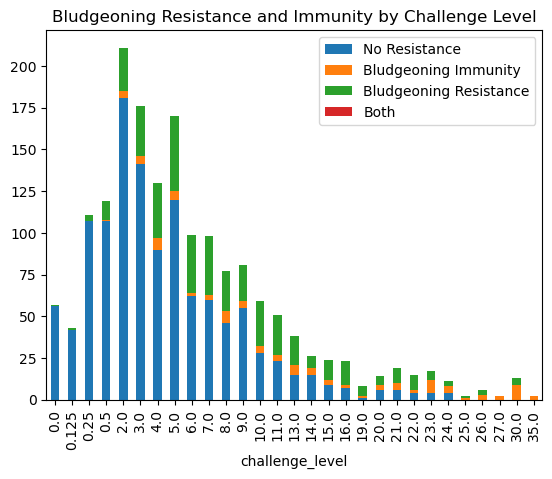

In [79]:
pivot_cols = ['challenge_level', 'damage_resistances_bludgeoning', 'damage_immunities_bludgeoning']
p_df = pd.DataFrame(df.groupby(pivot_cols).name.count()).pivot_table(index=pivot_cols[0], columns=pivot_cols[1:], values='name', fill_value=0)
p_df = p_df[p_df[( True,  True)] == False]
p_df.columns = ['No Resistance', 'Bludgeoning Immunity', 'Bludgeoning Resistance', 'Both']
p_df.plot(kind='bar', stacked=True)
plt.title('Bludgeoning Resistance and Immunity by Challenge Level')

In [80]:
p_df['percent_immune'] = p_df['Bludgeoning Immunity'] / (p_df['Bludgeoning Immunity'] + p_df['Bludgeoning Resistance'] + p_df['No Resistance']) 
p_df['percent_resistant'] = p_df['Bludgeoning Resistance'] / (p_df['Bludgeoning Immunity'] + p_df['Bludgeoning Resistance'] + p_df['No Resistance'])
p_df['percent_no_resistance'] = p_df['No Resistance'] / (p_df['Bludgeoning Immunity'] + p_df['Bludgeoning Resistance'] + p_df['No Resistance'])
p_df 

,No Resistance,Bludgeoning Immunity,Bludgeoning Resistance,Both,percent_immune,percent_resistant,percent_no_resistance
challenge_level,,,,,,,
0.000,56.0,0.0,1.0,0.0,0.000000,0.017544,0.982456
0.125,42.0,0.0,1.0,0.0,0.000000,0.023256,0.976744
0.250,107.0,0.0,4.0,0.0,0.000000,0.036036,0.963964
0.500,107.0,1.0,11.0,0.0,0.008403,0.092437,0.899160
2.000,181.0,4.0,26.0,0.0,0.018957,0.123223,0.857820
3.000,141.0,5.0,30.0,0.0,0.028409,0.170455,0.801136
4.000,90.0,7.0,33.0,0.0,0.053846,0.253846,0.692308
5.000,120.0,5.0,45.0,0.0,0.029412,0.264706,0.705882
6.000,62.0,2.0,35.0,0.0,0.020202,0.353535,0.626263


In [3]:
dnd.fundamental_math()

,Level_CR,Abl,Prof,Total,AC,Hit_Pcnt
0,1,3,2,5,13,65
1,2,3,2,5,13,65
2,3,3,2,5,13,65
3,4,4,2,6,14,65
4,5,4,3,7,15,65
5,6,4,3,7,15,65
6,7,4,3,7,15,65
7,8,5,3,8,16,65
8,9,5,4,9,16,70
9,10,5,4,9,17,65


In [33]:
level = 10
charisma = 4
agonizing_blast = charisma
proficiency_bonus = dnd.proficency_bonus(level)
hex = Dice(1, 6)
hex_warrior = proficiency_bonus
weapon_damage = Dice(1, 10)
weapon_bonus_damage = 3 + charisma + hex_warrior
to_hit = 10
# get dc
ac = dnd.get_AC(level)

smite = Dice(2, 8)


num_attacks = 3

adv = {'advantage':True, 'crit_on':20}

print('ts smite hw\t\t',
    dnd.roll_damage(ac, to_hit, weapon_damage, 
    bonus_damage=weapon_bonus_damage , **adv
    , crit_added_damage_dice=smite
).mean()*num_attacks)



ts smite hw		 49.2027


In [31]:
level = 10
charisma = 3
agonizing_blast = charisma
proficiency_bonus = dnd.proficency_bonus(level)
hex = Dice(1, 6)
hex_warrior = proficiency_bonus
weapon_damage = Dice(1, 10)
weapon_bonus_damage = 3 + charisma + charisma + hex_warrior
to_hit = 10
# get dc
ac = dnd.get_AC(level)

smite = Dice(2, 8)


num_attacks = 3

adv = {'advantage':True, 'crit_on':20}


print('ts smite hw\t\t',
    dnd.roll_damage(ac, to_hit, weapon_damage, 
    bonus_damage=weapon_bonus_damage , **adv
    , crit_added_damage_dice=smite
).mean()*num_attacks)



ts smite hw		 55.0791


In [33]:
Dice(2,8).expectation()*3

27.0

In [34]:
Dice(5,8).expectation()*3

67.5

In [45]:
Dice(1,6).expectation()

3.5

In [48]:
num_melee_skeletons = 4
num_ranged_skeletons = 5*2*8

print('sele attack \t',
    (dnd.roll_damage(20, 4+3, Dice(1, 6), 
    bonus_damage=3+5 
).mean() + dnd.roll_damage(20, 0+3, Dice(1, 6), 
    bonus_damage=3+5 
).mean())*num_melee_skeletons)

print('sele single attack \t',
    dnd.roll_damage(20, 4, Dice(1, 6), 
    bonus_damage=3, crit_on=20
).mean()*num_ranged_skeletons)

sele attack 	 28.732
sele single attack 	 146.376


In [53]:
level = 20
charisma = 5
agonizing_blast = charisma
proficiency_bonus = dnd.proficency_bonus(level)
hex = Dice(1, 6)
hex_warrior = proficiency_bonus
weapon_damage = Dice(1, 10)
weapon_bonus_damage = 3 + charisma + charisma

smite = Dice(5, 8)
eldritch_smite = Dice(5, 8)


eldritch_blast = Dice(1, 10)

num_attacks = 3
num_eb = 4

adv = {'advantage':False, 'crit_on':20}
total_wepon_damange = weapon_damage + weapon_bonus_damage

print('eb \t\t\t', dnd.roll_damage(20, 13, eldritch_blast+hex, bonus_damage=agonizing_blast).mean()*num_eb)
#print('eb double up\t\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast).mean()*num_eb*2)
print('eb cast hex warrior\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex_warrior, **adv).mean()*num_eb)
#print('eb double up after hw\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex_warrior, **adv).mean()*num_eb*2)

print('eb cast hex, hw\t\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex+hex_warrior, **adv).mean()*num_eb)
#print('eb loaded\t\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex+hex_warrior, **adv).mean()*num_eb*2)

print('eb cast hex\t\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex, **adv).mean()*num_eb)
#print('eb cast hex double up\t', dnd.roll_damage(20, 13, eldritch_blast, bonus_damage=agonizing_blast+hex, **adv).mean()*num_eb*2)
print()

print('ts smite hw\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10)+smite, 
    bonus_damage=weapon_bonus_damage+hex_warrior, **adv
).mean()*num_attacks)

print('ts smite eld_smite\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10)+smite, 
    bonus_damage=weapon_bonus_damage, **adv
).mean()*num_attacks+eldritch_smite.expectation())

print('ts smite eld_smite hw\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10)+smite, 
    bonus_damage=weapon_bonus_damage+hex_warrior, **adv
).mean()*num_attacks+eldritch_smite.expectation())

print('ts smite hex\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10)+smite, 
    bonus_damage=weapon_bonus_damage+hex, **adv
).mean()*num_attacks)


print('ts \t\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10), 
    bonus_damage=weapon_bonus_damage, **adv
).mean()*num_attacks)

print('ts smite sustainable\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10), 
    bonus_damage=weapon_bonus_damage+hex, 
    crit_added_damage_dice=smite+eldritch_smite,
    **adv
).mean()*num_attacks)

print('ts smite hex sustainable\t\t',
    dnd.roll_damage(20, 14, Dice(1, 10)+Dice(1,6), 
    bonus_damage=weapon_bonus_damage+hex, 
    crit_added_damage_dice=smite+eldritch_smite,
    **adv
).mean()*num_attacks)

print('eldritch_smite\t\t', eldritch_smite.expectation())

print('smite\t\t', smite.expectation())

print('sele magic stone \t',
    dnd.roll_damage(20, 2+5, Dice(1, 6), 
    bonus_damage=charisma , **adv
).mean())

print('sele single attack \t',
    dnd.roll_damage(20, 2+2+1, Dice(1, 6), 
    bonus_damage=3+5 , **adv
).mean())


eb 			 41.0
eb cast hex warrior	 47.3292


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [51]:
(Dice(1,6)+Dice(2,1)).expectation()

5.5

In [12]:
print('sele single attack \t',
    dnd.roll_damage(20, 2+2+1, Dice(1, 6), 
    bonus_damage=3 
).mean()*2*10)

sele single attack 	 41.536


In [177]:
def num_skele(level):
    return 4+(level-3)*2

num_skele(4) * 2 + num_skele(3)


16

In [119]:
dnd.spell_save_attack(5+5+Dice(1,4).expectation()+5,19, save_advantage=False).mean()

0.0999

In [268]:
weapon_bounus = 1
adv = {'advantage':False, 'crit_on':20}

dnd.roll_damage(
    20,
    4+weapon_bounus,
    Dice(1,6),
    bonus_damage=2+weapon_bounus+5,
    **adv
).mean()*5*2

36.255

In [277]:
weapon_bounus = 1
adv = {'advantage':False, 'crit_on':20}

dnd.roll_damage(
    20,
    4+weapon_bounus,
    Dice(1,6),
    bonus_damage=2+weapon_bounus+5,
    **adv
).mean()*5

18.5125

In [106]:

dnd.roll_damage(20, 4+3, 
    Dice(1,6) + Dice(1,6), 
    bonus_damage=2+3+10, **adv
).mean()*10

92.94399999999999

In [59]:
pally_attack[pally_attack>0].mean()

31.091598309719114

In [282]:
level = 20
charisma = 5
strength = 2
ability_score = charisma
melee_weapon = Dice(1,10) 
extra_dice = Dice(1,6) 
weapon_bonus = 3
bonus_damage = 2*charisma + weapon_bonus #+ dnd.proficency_bonus(level)
smite = Dice(4,8)+Dice(5,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 19
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon+extra_dice, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon+extra_dice, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4)+extra_dice, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save_attack(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2, save_advantage=True)
dex_saving_throw = dnd.spell_save_attack(-1 + ability_score, 10+level/2, save_advantage=True)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw failure:', wis_saving_throw.mean())
print('Dex saving throw failure:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack > 0).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.651
Wisdom saving throw failure: 0.3091
Dex saving throw failure: 0.659
Chance to hit: 0.8025
Damage for first round: 40.3118
Damage for second round: 57.9459


In [279]:
bonus_damage

19

In [49]:
charisma + charisma + weapon_bonus + dnd.proficency_bonus(level)

19

In [50]:
(melee_weapon+extra_dice).expectation()

9.0

In [52]:
np.percentile(pally_attack[pally_attack >0],50)

28.0

In [17]:
level = 8
charisma = 3
strength = 2
ability_score = charisma
melee_weapon = Dice(1,10) 
weapon_bonus = 3
bonus_damage = ability_score + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)



chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5491
Wisdom saving throw success: 0.2997
Dex saving throw success: 0.4532
Chance to hit: 0.7051
Damege per  hit: 8.8356
Damage for first round: 17.6002
Damage for second round: 24.0831


In [21]:
level = 9
charisma = 3
strength = 2
ability_score = strength
melee_weapon = Dice(1,10) + Dice(1,6)
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 19
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5975
Wisdom saving throw success: 0.6047
Dex saving throw success: 0.41
Chance to hit: 0.7041
Damege per  hit: 12.8745
Damage for first round: 25.7047
Damage for second round: 33.6623


In [22]:
level = 10
charisma = 3
strength = 2
ability_score = charisma
melee_weapon = Dice(1,10) + Dice(1,6)
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5929
Wisdom saving throw success: 0.6051
Dex saving throw success: 0.4003
Chance to hit: 0.6842
Damege per  hit: 13.1678
Damage for first round: 26.5701
Damage for second round: 35.1545


In [23]:
Dice(1,20).roll()+4

array([15])

In [24]:
level = 20
charisma = 5
strength = 3
ability_score = charisma 
melee_weapon = Dice(1,10) + Dice(1,8) + Dice(4,8)
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus + 6
smite = None
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':True, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:', dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.7035
Wisdom saving throw success: 0.5517
Dex saving throw success: 0.2378
Chance to hit: 0.9621
Damege per  hit: 47.9647
Damage for first round: 95.9405
Damage for second round: 116.8443


In [25]:
(dnd.roll_damage(18, 12, Dice(1,2), disadvantage=True) > 0).mean()

0.5629

In [26]:
dnd.spell_save(8, 10+level/2).mean()

0.4495

In [257]:
(dnd.roll_damage(22, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)>0).mean()

0.8821

Chace to  hit 0.5442
Chace to be hit 0.7058
Damage per round: 64.0574


<Axes: >

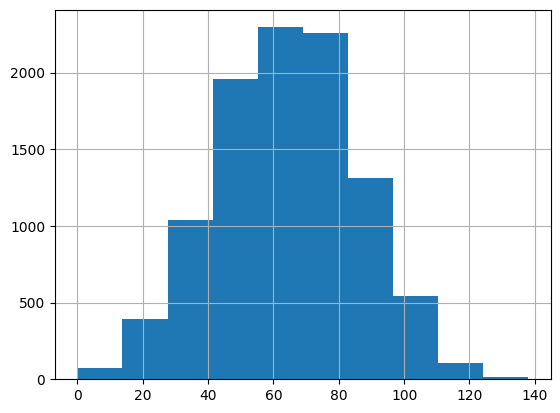

In [221]:
# skeletons 2 short swords
num_skeletons = 4
level = 12
charisma = 5
dex = 2
ability_score = None 
melee_weapon = Dice(1,6) + Dice(1,4)
weapon_bonus = 2
bonus_damage = None 
to_hit = 2 + dex + weapon_bonus
adv = {'advantage':False, 'crit_on':20}
enemy_ac = 16 #dnd.get_AC(level)

AC = 16
chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()


attacks = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + charisma + weapon_bonus, **adv)
print('Chace to  hit', (attacks>0).mean())
attacks += dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage= charisma + weapon_bonus, **adv)
for _ in range(num_skeletons -1):
    attacks += dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + charisma + weapon_bonus, **adv)
    attacks += dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage= charisma + weapon_bonus, **adv)

print('Chace to be hit', chance_to_be_hit)
print('Damage per round:', (attacks).mean())

pd.Series(attacks).hist()

Chace to be hit 0.8032
Damage per round: 112.1627


<Axes: >

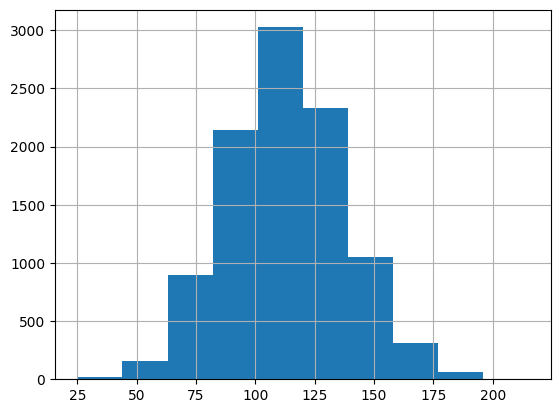

In [207]:
# skeletons bows
num_skeletons = 28
level = 20
charisma = 3
dex = 2
ability_score = None 
melee_weapon = Dice(1,6)
weapon_bonus = 0
bonus_damage = None 
to_hit = 7
adv = {'advantage':False, 'crit_on':20}
enemy_ac = dnd.get_AC(level)

AC = 16
chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()


attacks = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + charisma+ weapon_bonus, **adv)


for _ in range(num_skeletons -1):
    attacks += dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + charisma+ weapon_bonus, **adv)

print('Chace to be hit', chance_to_be_hit)
print('Damage per round:', (attacks).mean())

pd.Series(attacks).hist()

Chace to be hit 0.6949
Damage per round: 7.0573


<Axes: >

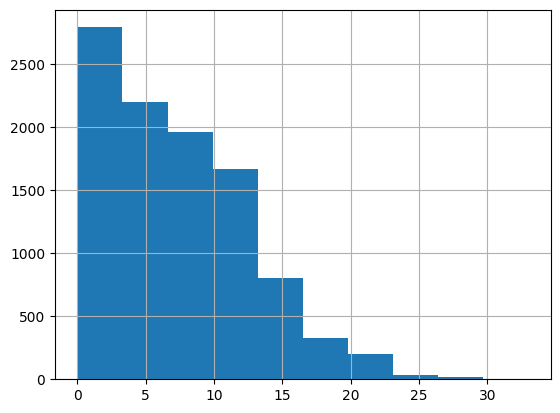

In [193]:
# skeletons bows
num_skeletons = 3
level = 12
charisma = 4
dex = 2
ability_score = None 
melee_weapon = Dice(1,6)
weapon_bonus = 0
bonus_damage = None 
to_hit = 2 + dex + weapon_bonus
adv = {'advantage':False, 'crit_on':20}
enemy_ac = dnd.get_AC(level)

AC = 16
chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()


attacks = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + weapon_bonus, **adv)


for _ in range(num_skeletons -1):
    attacks += dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=dex + weapon_bonus, **adv)

print('Chace to be hit', chance_to_be_hit)
print('Damage per round:', (attacks).mean())

pd.Series(attacks).hist()

In [143]:
level = 12
charisma = 4
strength = 4
ability_score = strength
melee_weapon = Dice(1,10) + Dice(1,8)
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.357
Wisdom saving throw success: 0.5954
Dex saving throw success: 0.3986
Chance to hit: 0.7438
Damege per  hit: 16.6003
Damage for first round: 33.1268
Damage for second round: 43.8057


In [130]:
level = 12
charisma = 4
strength = 4
ability_score = charisma
melee_weapon = Dice(1,10) + Dice(1,8)
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5979
Wisdom saving throw success: 0.5988
Dex saving throw success: 0.4072
Chance to hit: 0.7462
Damege per  hit: 16.6391
Damage for first round: 33.3151
Damage for second round: 43.9656


In [127]:
level = 11
charisma = 4
strength = 3
ability_score = strength
melee_weapon = Dice(1,10) + Dice(1,8) 
weapon_bonus = 3
bonus_damage = ability_score + charisma + weapon_bonus 
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score + weapon_bonus 
adv = {'advantage':False, 'crit_on':20}

enemy_ac = dnd.get_AC(level)
AC = 18
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + charisma + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + charisma, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(AC, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Chance to hit:', (pally_attack2 > 0).mean())
print('Damege per  hit:', (pally_attack2).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5895
Wisdom saving throw success: 0.5897
Dex saving throw success: 0.3966
Chance to hit: 0.7035
Damege per  hit: 15.0206
Damage for first round: 29.8117
Damage for second round: 39.1762


In [5]:
level = 6
ability_score = 2
melee_weapon = Dice(1,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite)
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite)

lvl_6_pally = pally_attack + pally_attack2 + pam_attack

wis_saving_throw = dnd.spell_save(-1 + 3 + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + 3, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Damage per round:', lvl_6_pally.mean())

Chace to be hit 0.3409
Wisdom saving throw success: 0.6605
Dex saving throw success: 0.49
Damage per round: 10.2391


In [6]:
level = 7
ability_score = 2
melee_weapon = Dice(1,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score+3

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite)
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.3526
Wisdom saving throw success: 0.5502
Dex saving throw success: 0.3988
Damage for first round: 10.5613
Damage for second round: 15.2529


In [145]:
dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,10)+Dice(1,6), bonus_damage=10).mean()

19.0823

In [7]:
level = 7
ability_score = 3
melee_weapon = Dice(2,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score
adv = {}#{'advantage':True, 'crit_on':19}

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,10)+Dice(1,6))
magic_stone = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,6), bonus_damage=ability_score*2)
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', magic_stone.mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.3484
Wisdom saving throw success: 0.5964
Dex saving throw: 0.4451
Edritch blast round: 9.2882
Magic stone round: 8.2107
Damage for first round: 13.6156
Damage for second round: 17.5467


In [8]:
level = 8
ability_score = 3
melee_weapon = Dice(2,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {}#{'advantage':True, 'crit_on':19}

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,10)+Dice(1,6))
magic_stone = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,6), bonus_damage=ability_score*2)
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Magic stone round:', magic_stone.mean())
print('Edritch blast round:', eldrith_blast.mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.3984
Wisdom saving throw success: 0.5916
Dex saving throw success: 0.4553
Magic stone round: 7.4949
Edritch blast round: 8.7422
Damage for first round: 15.7173
Damage for second round: 20.9847


In [9]:
level = 9
ability_score = 4
melee_weapon = Dice(2,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {}#{'advantage':True, 'crit_on':19}

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,10)+Dice(2,6))
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.4469
Wisdom saving throw success: 0.6561
Dex saving throw success: 0.4534
Edritch blast round: 12.6362
Damage for first round: 21.1131
Damage for second round: 28.4732


In [10]:
level = 10
ability_score = 4
melee_weapon = Dice(2,6)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {}#{'advantage':True, 'crit_on':19}

pally_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,10)+Dice(2,6), bonus_damage=ability_score*2) 
magic_stone = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(2,6)+Dice(2,6), bonus_damage=ability_score*2)
pally_attack2 = dnd.roll_damage(dnd.get_AC(level), to_hit, melee_weapon, bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(dnd.get_AC(level), to_hit, Dice(1,4), bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2)) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', magic_stone.mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.4517
Wisdom saving throw success: 0.6502
Dex saving throw success: 0.454
Edritch blast round: 16.4005
Magic stone round: 13.9873
Damage for first round: 19.6675
Damage for second round: 26.4957


In [ ]:
level = 14
ability_score = 5
melee_weapon = Dice(1,6) + Dice(1,8)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level) + ability_score
bonus_damage = ability_score * 2
adv = {'advantage':False, 'crit_on':19}
enemy_ac = dnd.get_AC(level)
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10)+Dice(3,6), bonus_damage=ability_score*3) 
normal_skele = dnd.roll_damage(enemy_ac, 2, Dice(3,6), bonus_damage=2) 

magic_stone = dnd.roll_damage(enemy_ac, to_hit, Dice(3,6), bonus_damage=ability_score*3)
magic_stone_eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10), bonus_damage=ability_score*3) 

pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', (magic_stone_eldrith_blast+magic_stone).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

In [33]:
level = 14
ability_score = 5
melee_weapon = Dice(1,6)+Dice(1,8)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {'advantage':False, 'crit_on':19}
enemy_ac = dnd.get_AC(level)
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10)+Dice(3,6), bonus_damage=ability_score*3) 
normal_skele = dnd.roll_damage(enemy_ac, 2, Dice(3,6), bonus_damage=2) 

magic_stone = dnd.roll_damage(enemy_ac, to_hit, Dice(3,6), bonus_damage=ability_score*3)
magic_stone_eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10), bonus_damage=ability_score*3) 

pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', (magic_stone_eldrith_blast+magic_stone).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.4907
Wisdom saving throw success: 0.6573
Dex saving throw success: 0.3969
Edritch blast round: 28.882
Magic stone round: 38.2805
Damage for first round: 26.8412
Damage for second round: 36.2194


In [34]:
level = 14
ability_score = 5
melee_weapon = Dice(1,6)+Dice(1,8)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {'advantage':True, 'crit_on':19}
enemy_ac = dnd.get_AC(level)
attackers_disadvantage = True

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10)+Dice(3,6), bonus_damage=ability_score*3) 
normal_skele = dnd.roll_damage(enemy_ac, 2, Dice(3,6), bonus_damage=2) 

magic_stone = dnd.roll_damage(enemy_ac, to_hit, Dice(3,6), bonus_damage=ability_score*3)
magic_stone_eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10), bonus_damage=ability_score*3) 

pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', (magic_stone_eldrith_blast+magic_stone).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.2512
Wisdom saving throw success: 0.6517
Dex saving throw success: 0.3972
Edritch blast round: 28.3892
Magic stone round: 38.684
Damage for first round: 38.2526
Damage for second round: 51.295


In [91]:
damage = 50.0 
level = 15
con = 8 
dex = 4
chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2), disadvantage=True) > 0).mean()

spell_save = dnd.advantage_roll(advantage=False, disadvantage=False, num_simulations=4000)

fail_spell_save = (19 > (dex + spell_save)).mean()

con_save = dnd.advantage_roll(advantage=False, disadvantage=False, num_simulations=4000)
con_DC = max(10.0, damage/2.0)
fail_con_check = (con_DC > (con_save+con)).mean() 

print('probablity to lose concentration (attack)', chance_to_be_hit * fail_con_check)
print('probablity to lose concentration (dex save)', fail_spell_save * fail_con_check)

probablity to lose concentration (attack) 0.20191420000000004
probablity to lose concentration (dex save) 0.3551165


In [92]:
level = 20
ability_score = 5
melee_weapon = Dice(1,6)+Dice(1,8)
smite = Dice(2,8)
to_hit = dnd.proficency_bonus(level)+ability_score
bonus_damage = ability_score*2
adv = {'advantage':False, 'crit_on':19}
enemy_ac = dnd.get_AC(level)
attackers_disadvantage = False

pally_attack = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10)+Dice(3,6), bonus_damage=ability_score*3) 
normal_skele = dnd.roll_damage(enemy_ac, 2, Dice(3,6), bonus_damage=2) 

magic_stone = dnd.roll_damage(enemy_ac, to_hit, Dice(3,6), bonus_damage=ability_score*3)
magic_stone_eldrith_blast = dnd.roll_damage(enemy_ac, to_hit, Dice(3,10), bonus_damage=ability_score*3) 

pally_attack2 = dnd.roll_damage(enemy_ac, to_hit, melee_weapon, bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)
pam_attack = dnd.roll_damage(enemy_ac, to_hit, Dice(1,4), bonus_damage=bonus_damage, crit_added_damage_dice=smite, **adv)

wis_saving_throw = dnd.spell_save(-1 + ability_score + dnd.proficency_bonus(level), 10+level/2)
dex_saving_throw = dnd.spell_save(-1 + ability_score, 10+level/2)

chance_to_be_hit = (dnd.roll_damage(21, dnd.attack_bonus(level), Dice(1,2), disadvantage=attackers_disadvantage) > 0).mean()

print('Chace to be hit', chance_to_be_hit)
print('Wisdom saving throw success:', wis_saving_throw.mean())
print('Dex saving throw success:',dex_saving_throw.mean())

print('Edritch blast round:', eldrith_blast.mean())
print('Magic stone round:', (magic_stone_eldrith_blast+magic_stone).mean())
print('Damage for first round:', (pally_attack + pally_attack2).mean())
print('Damage for second round:', (pally_attack + pally_attack2 + pam_attack).mean())

Chace to be hit 0.5423
Wisdom saving throw success: 0.5462
Dex saving throw success: 0.2522
Edritch blast round: 28.2727
Magic stone round: 38.1506
Damage for first round: 26.997
Damage for second round: 36.2165
